In [14]:
import os
import numpy as np
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader
import anndata as ad
from typing import Optional, Dict, Any
from tqdm import tqdm

from nicheformer.models import Nicheformer
from nicheformer.data import NicheformerDataset
import anndata as ad

## load nicheformer model 

In [15]:
os.getcwd()

'/home/ec2-user/SageMaker'

In [16]:
model_path=os.path.join("weights","nicheformer.ckpt")

In [19]:
pwd

'/home/ec2-user/SageMaker'

In [292]:
config = {
    'data_path': '/home/ec2-user/SageMaker/our_data_LC_NE/preprocessed/adata_sc_pre.h5ad', #'path/to/your/data.h5ad',  # Path to your AnnData file
    'technology_mean_path': '/home/ec2-user/SageMaker/nicheformer/data/model_means/merfish_mean_script.npy', #'path/to/technology_mean.npy',  # Path to technology mean file
    'checkpoint_path': '/home/ec2-user/SageMaker/weights/nicheformer.ckpt',  # Path to model checkpoint
    'output_path': 'test_data_with_embeddings.h5ad',  # Where to save the result, it is a new h5ad
    'output_dir': '/home/ec2-user/SageMaker/output_dir',  # Directory for any intermediate outputs
    'batch_size': 10,
    'max_seq_len': 1500, 
    'aux_tokens': 30, 
    'chunk_size': 1000, # to prevent OOM
    'num_workers': 4,
    'precision': 32,
    'embedding_layer': -1,  # Which layer to extract embeddings from (-1 for last layer)
    'embedding_name': 'embeddings'  # Name suffix for the embedding key in adata.obsm
}

In [293]:
model = Nicheformer.load_from_checkpoint(model_path, strict=False)
model.eval()  # Set to evaluation mode

# Configure trainer
trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    default_root_dir=config['output_dir'],
    precision=config.get('precision', 32),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [294]:
config['data_path']

'/home/ec2-user/SageMaker/our_data_LC_NE/preprocessed/adata_sc_pre.h5ad'

In [295]:
adata_0 = ad.read_h5ad(config['data_path'])
technology_mean=np.load(config['technology_mean_path'])
adata_orig = adata_0.copy()

In [296]:
adata_orig.var.index.shape,np.unique(list(adata_orig.var.index)).shape

((24343,), (24343,))

In [297]:
from nicheformer.data.constants import ObsConstants

In [298]:
adata_0.obs[ObsConstants.DATASET] = adata_0.uns['title']
adata_0.obs[ObsConstants.SPLIT] = 'train'
adata_0.obs[ObsConstants.NICHE] = 'nan'
adata_0.obs[ObsConstants.REGION] = 'nan'


# chnage orthologus genes

In [299]:
import pandas as pd

In [300]:
path_to_orthologus_csv = '/home/ec2-user/SageMaker/mouse_to_human.csv'
orthologus_csv = pd.read_csv(path_to_orthologus_csv)

In [301]:
orthologus_csv = orthologus_csv[orthologus_csv.hsapiens_homolog_ensembl_gene.notna()]
orthologus_csv

,Unnamed: 0,ensembl_gene_id,hsapiens_homolog_ensembl_gene
5,5,ENSMUSG00000064341,ENSG00000198888
9,9,ENSMUSG00000064345,ENSG00000198763
15,15,ENSMUSG00000064351,ENSG00000198804
18,18,ENSMUSG00000064354,ENSG00000198712
20,20,ENSMUSG00000064356,ENSG00000228253
...,...,...,...
83509,83509,ENSMUSG00000108908,ENSG00000186092
83510,83510,ENSMUSG00000108908,ENSG00000176695
83517,83517,ENSMUSG00000026679,ENSG00000151023
83518,83518,ENSMUSG00002076042,ENSG00000252396


In [302]:
foo = dict(zip(orthologus_csv.ensembl_gene_id, orthologus_csv.hsapiens_homolog_ensembl_gene))

In [303]:
adata_0.var=adata_0.var.rename(index=foo)

In [304]:
technology_mean=np.load(config['technology_mean_path'])

In [305]:
technology_mean.shape

(20310,)

In [306]:
model = ad.read_h5ad('/home/ec2-user/SageMaker/nicheformer/data/model_means/model.h5ad')

In [307]:
adata_0.var.index.shape,np.unique(list(adata_0.var.index)).shape

((24343,), (23911,))

In [308]:
adata_0.var[dup_indx]

,vf_vst_counts_mean,vf_vst_counts_variance,vf_vst_counts_variance.expected,vf_vst_counts_variance.standardized,vf_vst_counts_variable,vf_vst_counts_rank,var.features,var.features.rank,feature_is_filtered,n_cells,feature_name,feature_reference,feature_biotype
ENSG00000206579,61.878810,1221.013027,1174.224123,1.039847,False,-2147483648,NaN,-2147483648,False,5038,Xkr4,NCBITaxon:10090,gene
ENSMUSG00000089699,2.517827,4.964806,5.116678,0.970318,False,-2147483648,NaN,-2147483648,False,4226,Gm1992,NCBITaxon:10090,gene
ENSMUSG00000102331,1.174210,1.621345,1.895158,0.855520,False,-2147483648,NaN,-2147483648,False,3335,Gm19938,NCBITaxon:10090,gene
ENSMUSG00000102343,0.005542,0.006621,0.006652,0.995389,False,-2147483648,NaN,-2147483648,False,27,Gm37381,NCBITaxon:10090,gene
ENSG00000104237,0.028635,0.075492,0.038093,1.981753,True,1010,Rp1,1010,False,86,Rp1,NCBITaxon:10090,gene
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198886,13.629595,128.432066,72.826496,1.763535,True,1316,mt-Nd4,1316,False,5024,mt-Nd4,NCBITaxon:10090,gene
ENSG00000198786,6.127656,33.074056,19.153600,1.726780,True,1384,mt-Nd5,1384,False,4796,mt-Nd5,NCBITaxon:10090,gene
ENSG00000198695,0.627748,1.048579,0.921264,1.138197,False,-2147483648,NaN,-2147483648,False,1954,mt-Nd6,NCBITaxon:10090,gene
ENSG00000198727,11.063920,76.331095,50.867277,1.500593,True,1908,mt-Cytb,1908,False,5004,mt-Cytb,NCBITaxon:10090,gene


In [309]:
dup_indx = ~adata_0.var.index.duplicated(keep='first')
#adata_0.var = adata_0.var[dup_indx]
adata_0 = adata_0[:,dup_indx]

In [310]:
adata_0.var.shape, np.unique(list(adata_0.var.index)).shape

((23911, 13), (23911,))

In [311]:
keep_genes = [m in set(model.var.index) for m in adata_0.var.index]

In [312]:
adata_0 = adata_0[:, keep_genes]

In [313]:
adata_0.shape

(5040, 15661)

In [314]:
adata = ad.concat([model, adata_0], join='outer', axis=0)
# dropping the first observation 
adata = adata[1:].copy()

In [315]:
adata.shape

(5040, 20310)

In [316]:
# Create dataset
dataset = NicheformerDataset(
    adata=adata,
    technology_mean=technology_mean,
    split='train',
    max_seq_len=1500,
    aux_tokens=config.get('aux_tokens', 30),
    chunk_size=config.get('chunk_size', 1000)
)

100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


In [317]:


# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config.get('num_workers', 4),
    pin_memory=True
)

In [318]:
dataloader

In [319]:
trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    default_root_dir=config['output_dir'],
    precision=config.get('precision', 32),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [320]:
Niche_model = Nicheformer.load_from_checkpoint(model_path, strict=False)
Niche_model.eval()  # Set to evaluation mode

# Configure trainer
trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=4,
    default_root_dir=config['output_dir'],
    precision=config.get('precision', 32),
)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['pos']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [321]:
print("Extracting embeddings...")
embeddings = []
device = Niche_model.embeddings.weight.device

with torch.no_grad():
    for batch in tqdm(dataloader):
        # Move batch to device
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in batch.items()}

        # Get embeddings from the model
        emb = Niche_model.get_embeddings(
            batch=batch,
            layer=config.get('embedding_layer', -1)  # Default to last layer
        )
        embeddings.append(emb.cpu().numpy())


# Concatenate all embeddings
embeddings = np.concatenate(embeddings, axis=0)

Extracting embeddings...


100%|██████████| 504/504 [02:36<00:00,  3.22it/s]


In [331]:
adata.obsm

AxisArrays with keys: 

In [339]:
adata.obsm['nicheformer'] = embeddings

adata.write_h5ad('/home/ec2-user/SageMaker/output_dir/adata_sc_embedded.h5ad')

In [338]:

adata.obsm['nicheformer_MDE'] = scvi.model.utils.mde(adata.obsm['nicheformer'], accelerator="gpu")

NameError: name 'scvi' is not defined

In [325]:
import matplotlib.pyplot as plt

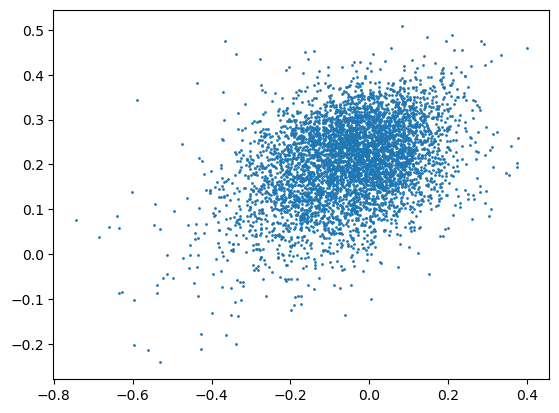

In [329]:
plt.scatter(embeddings[:,2],embeddings[:,3], s =1 )